# Conjunto de Dados

O dataset utilizado é o [GTZAN Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification), um conjunto de dados com 1000 faixas de áudio com 30 segundos de duração cada separados em 10 gêneros musicais, cada um com 100 faixas. As faixas estão no formato .wav e codificadas em mono 16-bits 22.050Hz. Os gêneros das faixas são: Blues, clássica, country, disco, hiphop, jazz, metal, raggae e rock.


##Instalando a API do Kaggle


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kenzoinanamidefaria","key":"498b3c4fc8eefc02f2aa857d32afce48"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Baixando o conjunto de dados


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:31<00:00, 41.3MB/s]
100% 1.21G/1.21G [00:31<00:00, 41.6MB/s]


In [ ]:
!unzip *.zip

## Extraindo informações do áudio


Para utilizar uma CNN, espectrogramas foram gerados a partir das faixas de áudio para sua análise e processamento.

Espectrogramas são gráficos que mostram a intensidade de som e suas diferentes frequências em um determinado período de tempo.


In [ ]:
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import imageio

root_dir = 'Data/genres_original'
output_dir = 'spectrograms'

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


n_mels = 128
hop_length = 512
n_fft = 2048
segment_duration = 3
images = []
labels = []
for genre in genres:
    genre_dir = os.path.join(root_dir, genre)
    label = genre
    print(genre)
    for filename in os.listdir(genre_dir):
        audio_path = os.path.join(genre_dir, filename)
        try:
          y, sr = librosa.load(audio_path)

          segment_length = segment_duration * sr
          n_samples = len(y)
          start_sample = 0
          for i in range(10):
              start_sample = np.random.randint(0, n_samples - segment_length)
              end_sample = int(start_sample + segment_length)
              segment = y[start_sample:end_sample]

              mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels,
                                                        hop_length=hop_length, n_fft=n_fft)
              log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
              images.append(log_mel_spec)
              labels.append(label)
              start_sample = end_sample
        except:
          print("Erro em "+audio_path)

print("Espectrogramas gerados e salvos com sucesso!")


blues
classical
country
disco
hiphop
jazz


<ipython-input-6-8977e3cf422d>:27: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro em Data/genres_original/jazz/jazz.00054.wav
metal
pop
reggae
rock
Espectrogramas gerados e salvos com sucesso!


In [ ]:
import pandas as pd
data = {'Spectrograms': images, 'Labels': labels}
df = pd.DataFrame(data)
df.head()

,Spectrograms,Labels
0,"[[-37.840813, -34.649063, -26.941582, -26.0221...",blues
1,"[[-13.294512, -13.652378, -16.593456, -21.5957...",blues
2,"[[-21.824846, -20.979923, -22.00462, -20.10903...",blues
3,"[[-24.147852, -29.25016, -40.832737, -33.93087...",blues
4,"[[-28.702051, -34.46402, -32.883675, -30.86120...",blues


In [ ]:
df.shape

(9990, 2)

In [ ]:
df['Spectrograms'][0].shape

(128, 130)

Um exemplo da extração de segmentos de áudio e a criação de um espectrograma Mel.

Esse tipo se difere de um espectrograma pois tem suas frequências convertidas para a escala de Mel, através de uma transformação logaritmica, para representar com mais importância as frequências audíveis pela audição humana.


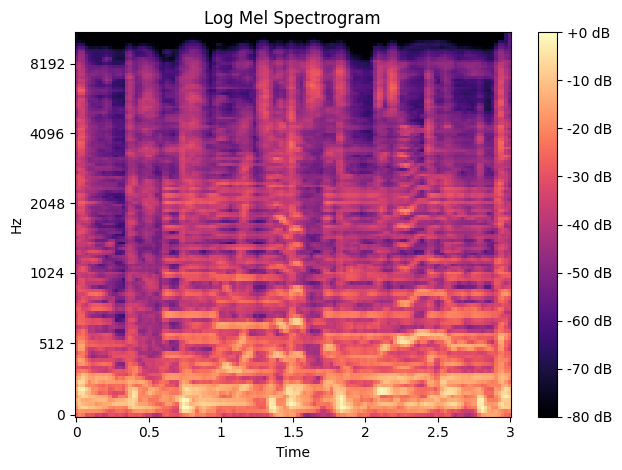

In [ ]:
y, sr = librosa.load(audio_path, duration=segment_duration)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
df.iloc[0][0].shape

(128, 130)

In [ ]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


In [ ]:
segment_duration = 30
n_mels = 128
hop_length = 512
n_fft = 1024


Divisão entre treino e teste com 20% dos dados utilizados para teste.

A labels são convertidas para um formato numérico.


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
images = np.array(df['Spectrograms'].tolist())
labels = df['Labels'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


A arquitetura deste modelo é caracterizada por uma sequencia de 3 camadas convolucionais, intercaladas por três max-pooling para a captura de padrões espaciais dos espectrogramas. São seguidas por uma camada dense com ativação ReLU, uma camada dropout para evitar overfitting e uma camada dense com ativação softmax. O modelo é então compilado com o otimizador adam e a acurácia é utilizada como medida de avaliação.


In [ ]:
model = Sequential([
    Conv2D(16, (7, 7), activation='relu', input_shape=(n_mels, X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')  # Camada de saída
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Treino do modelo com 10 épocas e 10% separados para avaliação.


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
225/225 [==============================] - 9s 13ms/step - loss: 2.3214 - accuracy: 0.0934 - val_loss: 2.3028 - val_accuracy: 0.0887
Epoch 2/10
225/225 [==============================] - 2s 9ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3032 - val_accuracy: 0.0887
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3034 - val_accuracy: 0.0887
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 2.3027 - accuracy: 0.1009 - val_loss: 2.3034 - val_accuracy: 0.0887
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3037 - val_accuracy: 0.0887
Epoch 6/10
225/225 [==============================] - 2s 9ms/step - loss: 2.3027 - accuracy: 0.1012 - val_loss: 2.3037 - val_accuracy: 0.0887
Epoch 7/10
225/225 [==============================] - 2s 9ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3038 - val_accuracy: 0.0887
Ep

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 8ms/step - loss: 2.3032 - accuracy: 0.0941
Test accuracy: 0.09409409761428833


# Outros modelos testados


## Modelo 2


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
225/225 [==============================] - 8s 21ms/step - loss: 2.5824 - accuracy: 0.1008 - val_loss: 2.3042 - val_accuracy: 0.0887
Epoch 2/10
225/225 [==============================] - 4s 19ms/step - loss: 2.3036 - accuracy: 0.1004 - val_loss: 2.3033 - val_accuracy: 0.0950
Epoch 3/10
225/225 [==============================] - 5s 23ms/step - loss: 2.3033 - accuracy: 0.1016 - val_loss: 2.3030 - val_accuracy: 0.0887
Epoch 4/10
225/225 [==============================] - 4s 20ms/step - loss: 2.3033 - accuracy: 0.0945 - val_loss: 2.3037 - val_accuracy: 0.0887
Epoch 5/10
225/225 [==============================] - 4s 19ms/step - loss: 2.3026 - accuracy: 0.0972 - val_loss: 2.3036 - val_accuracy: 0.0887
Epoch 6/10
225/225 [==============================] - 4s 18ms/step - loss: 2.3028 - accuracy: 0.1053 - val_loss: 2.3038 - val_accuracy: 0.0887
Epoch 7/10
225/225 [==============================] - 4s 18ms/step - loss: 2.3031 - accuracy: 0.0987 - val_loss: 2.3039 - val_accuracy: 0.0887

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 8ms/step - loss: 2.3030 - accuracy: 0.0941
Test accuracy: 0.09409409761428833


## Modelo 3


In [ ]:
df['Labels'] = pd.Categorical(df['Labels'])
df['Labels'] = df.Labels.cat.codes

l = df.pop('Labels')
dataset = tf.data.Dataset.from_tensor_slices((np.array(images), l.values))

In [ ]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 128, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 31, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 30, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1600)             

In [ ]:
import tensorflow as tf

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 124, 126, 32)      832       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 61, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 57600)             0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
225/225 [==============================] - 6s 18ms/step - loss: 4.7344 - accuracy: 0.2835 - val_loss: 1.4447 - val_accuracy: 0.4850
Epoch 2/20
225/225 [==============================] - 3s 15ms/step - loss: 1.2063 - accuracy: 0.5768 - val_loss: 1.1164 - val_accuracy: 0.6075
Epoch 3/20
225/225 [==============================] - 3s 14ms/step - loss: 0.7473 - accuracy: 0.7453 - val_loss: 1.0545 - val_accuracy: 0.6488
Epoch 4/20
225/225 [==============================] - 3s 13ms/step - loss: 0.5162 - accuracy: 0.8259 - val_loss: 1.1650 - val_accuracy: 0.6388
Epoch 5/20
225/225 [==============================] - 3s 13ms/step - loss: 0.2953 - accuracy: 0.9032 - val_loss: 1.2856 - val_accuracy: 0.6650
Epoch 6/20
225/225 [==============================] - 3s 14ms/step - loss: 0.1719 - accuracy: 0.9431 - val_loss: 1.3818 - val_accuracy: 0.6675
Epoch 7/20
225/225 [==============================] - 3s 14ms/step - loss: 0.0878 - accuracy: 0.9721 - val_loss: 1.5203 - val_accuracy: 0.6625

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 8ms/step - loss: 2.7488 - accuracy: 0.6532
Test accuracy: 0.6531531810760498


## Modelo 4


In [ ]:
model1 = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),

    Dense(10, activation='softmax')
])
model1.summary()
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 124, 126, 32)      832       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 57600)             0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [ ]:
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
225/225 [==============================] - 5s 16ms/step - loss: 2.7207 - accuracy: 0.0947 - val_loss: 2.3028 - val_accuracy: 0.0950
Epoch 2/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3028 - accuracy: 0.0969 - val_loss: 2.3031 - val_accuracy: 0.0950
Epoch 3/10
225/225 [==============================] - 3s 13ms/step - loss: 2.3027 - accuracy: 0.1008 - val_loss: 2.3032 - val_accuracy: 0.0887
Epoch 4/10
225/225 [==============================] - 3s 13ms/step - loss: 2.3027 - accuracy: 0.0986 - val_loss: 2.3034 - val_accuracy: 0.0887
Epoch 5/10
225/225 [==============================] - 3s 13ms/step - loss: 2.3027 - accuracy: 0.1005 - val_loss: 2.3035 - val_accuracy: 0.0887
Epoch 6/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3027 - accuracy: 0.1018 - val_loss: 2.3036 - val_accuracy: 0.0887
Epoch 7/10
225/225 [==============================] - 3s 13ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3036 - val_accuracy: 0.0887

In [ ]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 7ms/step - loss: 2.3031 - accuracy: 0.0941
Test accuracy: 0.09409409761428833


## Modelo 5


In [ ]:
model4 = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model4.summary()
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 126, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 57600)             0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
225/225 [==============================] - 6s 20ms/step - loss: 7.7632 - accuracy: 0.2369 - val_loss: 1.8881 - val_accuracy: 0.4225
Epoch 2/10
225/225 [==============================] - 4s 17ms/step - loss: 1.3662 - accuracy: 0.5302 - val_loss: 1.3340 - val_accuracy: 0.5450
Epoch 3/10
225/225 [==============================] - 4s 17ms/step - loss: 0.7661 - accuracy: 0.7379 - val_loss: 1.1349 - val_accuracy: 0.6288
Epoch 4/10
225/225 [==============================] - 4s 17ms/step - loss: 0.3496 - accuracy: 0.8835 - val_loss: 1.1235 - val_accuracy: 0.6700
Epoch 5/10
225/225 [==============================] - 4s 18ms/step - loss: 0.1598 - accuracy: 0.9508 - val_loss: 1.3264 - val_accuracy: 0.6787
Epoch 6/10
225/225 [==============================] - 4s 17ms/step - loss: 0.0811 - accuracy: 0.9775 - val_loss: 1.6768 - val_accuracy: 0.6300
Epoch 7/10
225/225 [==============================] - 4s 17ms/step - loss: 0.1025 - accuracy: 0.9675 - val_loss: 1.8372 - val_accuracy: 0.6000

In [ ]:
test_loss, test_accuracy = model4.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 6ms/step - loss: 1.9252 - accuracy: 0.6662
Test accuracy: 0.6661661863327026


## Modelo 6


In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),

    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),


    Dense(10, activation='softmax')
])
model2.summary()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 63, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 31, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 59520)             0         
                                                                 
 dense_19 (Dense)            (None, 64)               

In [ ]:
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
225/225 [==============================] - 5s 15ms/step - loss: 4.5688 - accuracy: 0.0939 - val_loss: 2.3026 - val_accuracy: 0.1200
Epoch 2/10
225/225 [==============================] - 3s 15ms/step - loss: 2.3028 - accuracy: 0.0984 - val_loss: 2.3028 - val_accuracy: 0.0887
Epoch 3/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3027 - accuracy: 0.1003 - val_loss: 2.3031 - val_accuracy: 0.0887
Epoch 4/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3028 - accuracy: 0.1029 - val_loss: 2.3034 - val_accuracy: 0.0887
Epoch 5/10
225/225 [==============================] - 3s 13ms/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3034 - val_accuracy: 0.0887
Epoch 6/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3036 - val_accuracy: 0.0887
Epoch 7/10
225/225 [==============================] - 3s 14ms/step - loss: 2.3031 - accuracy: 0.1036 - val_loss: 2.3029 - val_accuracy: 0.0925

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 6ms/step - loss: 2.3031 - accuracy: 0.0941
Test accuracy: 0.09409409761428833


## Conclusão


Para classificar músicas com CNNs recorremos aos mel-espectrogramas, assim pudemos constatar que músicas em um gênero musical possuem características únicas entre si que podem ser aprendidas por redes neurais.
